# Assignment 6: Explainable Techniques II

Kelly Tong

Link to Colab: https://colab.research.google.com/drive/1NVT9rOhLr0QYirHnWoHItwHFVoUR7Ewp#scrollTo=AGHZDXY-pmPf

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kelly0604/Assignment6_Explainable_TechniquesII/blob/main/Assignment6_Explainable_TechniquesII.ipynb)

In [ ]:
# Link to Github
!git clone https://github.com/Kelly0604/Assignment6_Explainable_TechniquesII.git
%cd /content/Assignment6_Explainable_TechniquesII
%ls
# update
!git pull

fatal: destination path 'Assignment6_Explainable_TechniquesII' already exists and is not an empty directory.
/content/Assignment6_Explainable_TechniquesII
Assignment6_Explainable_TechniquesII/  README.md  winequality_red.csv
Already up to date.


## Installing and Loading neccessary packages

In [ ]:
!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1 xgboost==1.7.5

In [ ]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-ym0kskh2/alepython_3c49b4bae7a54166915ae3e3f7d053b1
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-ym0kskh2/alepython_3c49b4bae7a54166915ae3e3f7d053b1
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=2138bd28c61a798b3c9bac10ebb339370a3d7cc6d937a0fc90c3f41bc6fa04d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-f49nnzr_/wheels/80/2e/91/7f216caef9a7f0c6ce18ee562b6156df43b3a79f69a0c1f3d1
Successfully built alepython


In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)

## Load Data

In [ ]:
# load data
data = pd.read_csv('winequality_red.csv')

In [ ]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

## Train a XGBoost model on the data

In [ ]:
# Split the data into features and target
X = data.drop(columns=['quality'])
y = data['quality']

# Encode the target variable to have sequential integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier with reduced estimators
xgb_model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=50)
xgb_model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy}")


Model accuracy: 0.675


## Partial Dependence Plot (PDP)  

In [ ]:
print(label_encoder.classes_)

[3 4 5 6 7 8]


Class 0 corresponds to red wine quality of score 3, which is the lowest quality red wine. Class 5 corresponds to red wine quality of score 8, which is the highest quality red wine.

In [ ]:
features = [X.columns.get_loc('alcohol')]

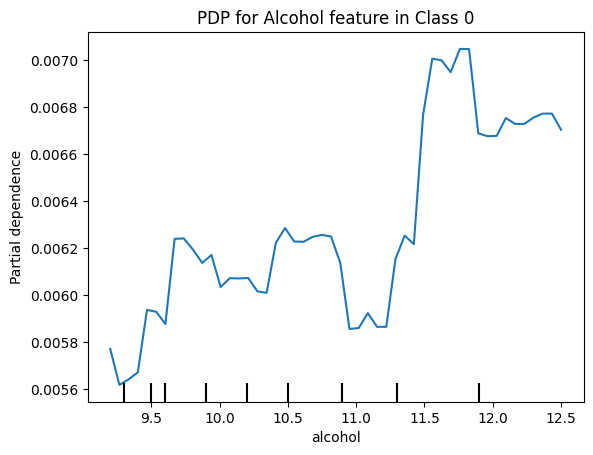

In [ ]:
# Plot the PDP for the 'alcohol' feature, target = 0
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features, target=0, kind='average', grid_resolution=50)
plt.title("PDP for Alcohol feature in Class 0")
plt.show()

The plot shows that as the alcohol level increases (from around 9.5 to 12.5), the partial dependence increases slightly and then fluctuates. The peak in the dependence score suggests that higher alcohol levels might positively influence the model's predictions for this class up to a certain point.

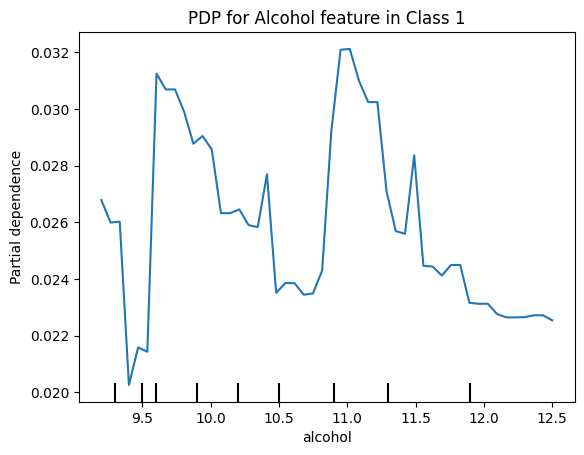

In [ ]:
# Plot the PDP for the 'alcohol' feature, target = 1
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features, target=1, kind='average', grid_resolution=50)
plt.title("PDP for Alcohol feature in Class 1")
plt.show()

 In this plot, we see a more significant fluctuation in the partial dependence score. The model seems to associate higher alcohol levels with a greater likelihood of predicting this class, but the effect is more erratic compared to the first plot. There is a sharp increase in partial dependence at certain alcohol levels, indicating that for this class, higher alcohol content has a stronger influence on predictions.

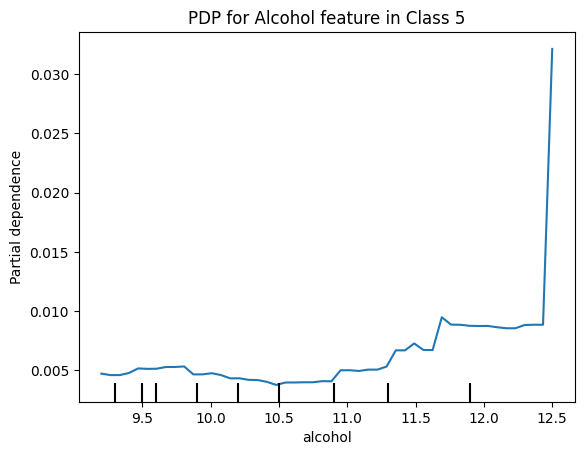

In [ ]:
# Plot the PDP for the 'alcohol' feature, target = 5
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features, target=5, kind='average', grid_resolution=50)
plt.title("PDP for Alcohol feature in Class 5")
plt.show()

In this case, the plot shows a steady partial dependence at lower alcohol levels, followed by a sharp increase as the alcohol level approaches 12.5. This indicates that higher alcohol content strongly pushes predictions toward this class. This sharp upward trend suggests that the model associates higher alcohol content with higher wine quality scores.

### Key Observations

- Fluctuations in dependence: The PDPs for different target classes (different quality levels) show varying levels of fluctuation in the partial dependence. This indicates that the relationship between alcohol content and predicted wine quality is not linear or consistent across all classes.

- Higher alcohol content: Across the plots, there seems to be a trend where higher alcohol content (closer to 12.5) generally leads to an increase in the model's prediction probability for higher-quality wine classes (especially noticeable in the third plot).

## ICE Plots

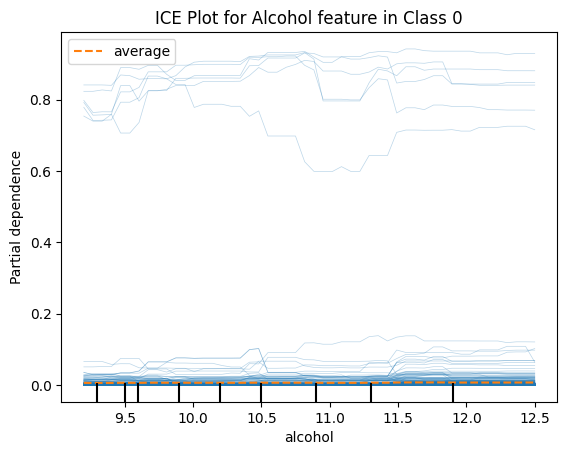

In [ ]:
# Plot the PDP and ICE for the 'alcohol' feature, target = 0
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features, target=0, kind='both', grid_resolution=50)
plt.title("ICE Plot for Alcohol feature in Class 0")
plt.show()

The majority of the blue ICE curves show a flat, almost zero response as alcohol increases, indicating that for most instances, changes in alcohol content have little to no effect on the prediction probability of class 0. However, there are some individual instances where the partial dependence for class 0 increases dramatically as alcohol increases. These few curves suggest that in some rare cases, the model may associate high alcohol content with a higher likelihood of predicting class 0, but this behavior is not typical. The average effect (orange line) remains close to zero across the range of alcohol, meaning that overall, the model does not strongly associate alcohol with predicting the lowest wine quality class.

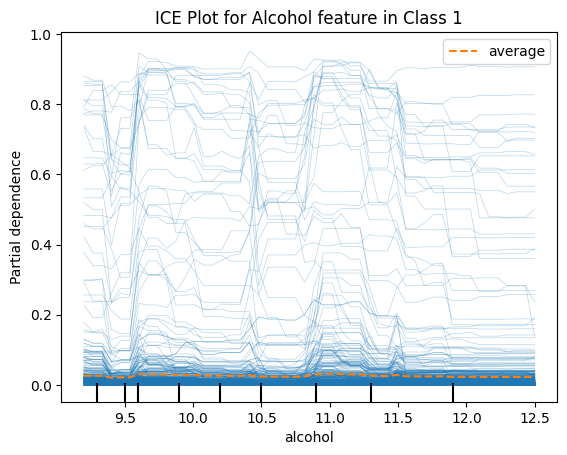

In [ ]:
# Plot the PDP and ICE for the 'alcohol' feature, target = 1
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features, target=1, kind='both', grid_resolution=50)
plt.title("ICE Plot for Alcohol feature in Class 1")
plt.show()

The individual curves in class 1 exhibit more variability compared to class 0. The ICE curves show more pronounced changes as alcohol content increases. Many individual lines show a non-linear pattern with spikes and dips in the probability of predicting class 1. The PDP (orange line) still remains relatively low, but it is slightly higher than that of class 0, indicating that, on average, the probability of predicting class 1 increases a little more as alcohol rises. Some ICE curves show dramatic increases in partial dependence at certain points of alcohol, suggesting that the model strongly associates high alcohol levels with a higher probability of class 1 for certain instances, though this effect is not consistent across all instances.

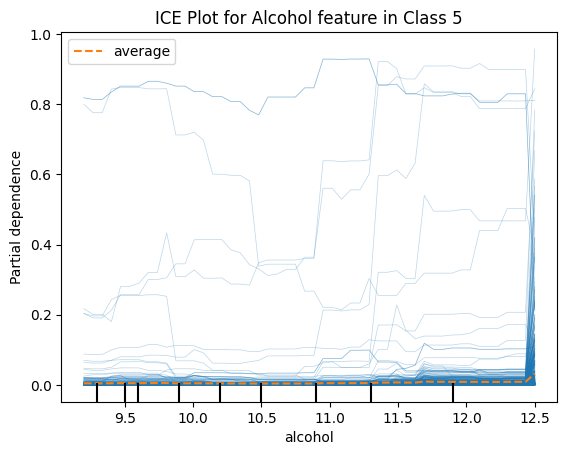

In [ ]:
# Plot the PDP and ICE for the 'alcohol' feature, target = 5
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features, target=5, kind='both', grid_resolution=50)
plt.title("ICE Plot for Alcohol feature in Class 5")
plt.show()

In this plot, the individual ICE curves clearly show an upward trend as alcohol increases. For many instances, the probability of predicting class 5 (the highest wine quality) increases significantly with higher alcohol content. The average effect (PDP) reflects this positive trend, showing a marked increase in partial dependence as alcohol approaches 12.5. This suggests that, on average, higher alcohol content is strongly associated with a higher likelihood of predicting the highest wine quality class. While most ICE curves follow the same upward trend, there is some variation in the exact point at which the probability starts to increase. This suggests that the influence of alcohol content on predicting high-quality wine varies slightly across instances, but the overall trend is consistent.

Key takeaway: For class 5, the model strongly associates higher alcohol content with higher wine quality. The ICE curves indicate that across most instances, an increase in alcohol leads to a higher probability of predicting the best wine quality.

### Interesting Findigs
- Contrast between classes: The influence of alcohol on predictions varies significantly across classes. While the effect is negligible for class 0 (lowest quality) and moderate for class 1 (second lowest), it is very strong for class 5 (highest quality).

- Non-linear behavior: In class 1, we observe a non-linear pattern where the effect of alcohol spikes and dips for different instances. This suggests that the model's behavior in predicting this class is more complex and may depend on interactions with other features.

- Clear positive correlation for class 5: The ICE curves for class 5 show a consistent upward trend, meaning that higher alcohol content consistently boosts the model's confidence in predicting higher wine quality.

## ALE Plot

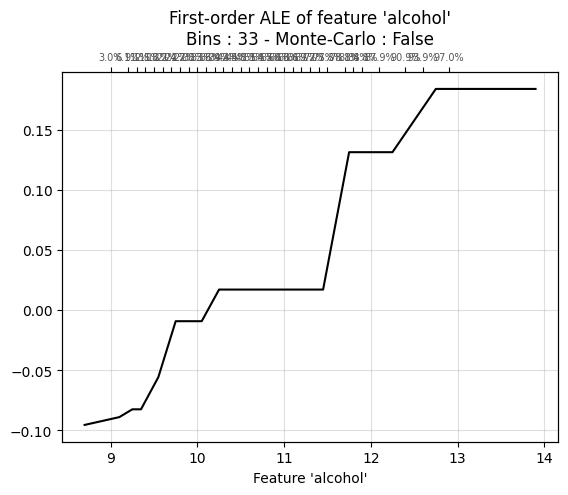

In [ ]:
ale_plot(xgb_model, X_train, 'alcohol', bins=50)
plt.show()

The curve starts around -0.10 and rises to above 0.15 as alcohol levels increase.
There are notable "steps" around values 10, 11, and 12, indicating that increasing alcohol content significantly affects the predictions for these ranges.

The upward slope suggests that as alcohol content increases, the model predicts a higher wine quality score on average. Steeper sections of the curve (between 10-12) imply that changes in alcohol content in this range have a larger impact on the predictions than at lower or higher values.

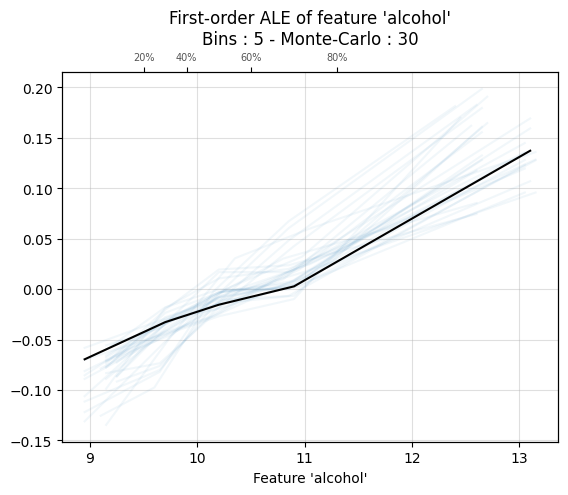

<Axes: title={'center': "First-order ALE of feature 'alcohol'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'alcohol'">

In [ ]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    xgb_model,
    X_train,
    "alcohol",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

Similar to the previous plot, the curve shows a clear upward trend, with alcohol values between 9 and 13 leading to higher predictions.

The Monte Carlo sampling (light blue lines) shows that while there is some variation in the effect of alcohol, the overall upward trend is consistent.

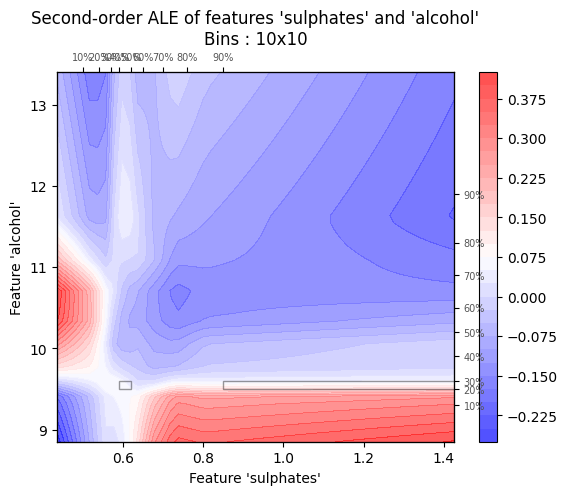

<Axes: title={'center': "Second-order ALE of features 'sulphates' and 'alcohol'\nBins : 10x10"}, xlabel="Feature 'sulphates'", ylabel="Feature 'alcohol'">

In [56]:
# 2D Second-Order ALE Plot
ale_plot(xgb_model, X_train, X_train.columns[9:], bins=10)

Color scale (ALE values):

The color represents the joint effect of alcohol and sulphates on the predictions. Red regions correspond to higher ALE values (higher predicted wine quality), while blue regions correspond to lower ALE values (lower predicted wine quality).

Pattern:

- Higher alcohol and higher sulphates: The top right corner (high alcohol and high sulphates) shows a red region, indicating that the combination of high alcohol and high sulphates is strongly associated with higher predicted wine quality.
- Low alcohol and low sulphates: In contrast, the bottom left corner (low alcohol and low sulphates) is blue, suggesting that lower values of both features are associated with lower predictions of wine quality.
- Sharp boundary: The transition between these regions is quite sharp, indicating a strong joint effect between these two features. In the middle region, the effects are more moderate, suggesting that predictions are less influenced by changes in alcohol and sulphates when both features are at average levels.

## Conclusion

Key Difference between PDP and ALE Plots

- Bias in PDPs: PDPs may become biased when there are correlations between the feature of interest (alcohol) and other features (like sulphates). This is because PDP assumes the independence of features, while ALE explicitly accounts for the correlations. This can lead to differences in interpretation, particularly in the presence of strong correlations between features.

- Smoother Transitions in ALE: The ALE plot, especially for alcohol, shows smoother and more gradual transitions in the effect of alcohol, particularly around mid-level values of alcohol (10-12). The PDP, on the other hand, may show more abrupt changes or non-linear behavior due to interactions between features not being considered in the PDP calculation.

- Handling Feature Correlation: When handlig feature correlation, PDP accounts for the global average effect. In the PDP for alcohol, we observe sharp jumps, especially in the middle alcohol ranges (around 10-12), which may be exaggerated by correlations between alcohol and other features. PDP does not account for these correlations, so it gives a more global view of how alcohol affects predictions. ALE accouts for conditional local effects. ALE plots are designed to handle these correlations by calculating changes in predictions only within regions of the feature space where the feature of interest is varied. The ALE plot for alcohol shows a more refined understanding, where the effect of alcohol on wine quality is more moderate but still increases over time without the abrupt jumps seen in the PDP.

Exploratory findings

- Alcohol increment seems to improve the red wine quality
- Relationship betwee alcohol level and other features, such as sulphates, is complex and might not be a linear relationship
